## 1. 모듈/라이브러리 임포트

In [37]:
import torch, os
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image
from torchvision.utils import make_grid
from torch.autograd import Variable
import matplotlib.pyplot as plt

## 2. 하이퍼 파라메터 세팅

In [38]:
max_epoch = 20
batch_size = 100
lr = 0.0002
z_dim = 64
output_dir = './output/'
if not os.path.exists(output_dir) : os.makedirs(output_dir)

## 3. 데이터 준비

In [39]:
# Image processing
transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(mean=(0.5, 0.5, 0.5),
                                     std=(0.5, 0.5, 0.5))])
# MNIST dataset
mnist = datasets.MNIST(root='./data/',
                       train=True,
                       transform=transform,
                       download=True)
# Data loader
data_loader = torch.utils.data.DataLoader(dataset=mnist,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          drop_last=True)

## 4. 모델 정의

<img src="./GAN.png" width="400">

In [40]:
# Discriminator
D = nn.Sequential(
    nn.Linear(784, 256),
    nn.LeakyReLU(0.2),
    nn.Linear(256, 256),
    nn.LeakyReLU(0.2),
    nn.Linear(256, 1),
    nn.Sigmoid())

# Generator
G = nn.Sequential(
    nn.Linear(z_dim, 256),
    nn.LeakyReLU(0.2),
    nn.Linear(256, 256),
    nn.LeakyReLU(0.2),
    nn.Linear(256, 784),
    nn.Tanh())

if torch.cuda.is_available():
    D.cuda()
    G.cuda()

## 5. Loss/Optimizer

In [41]:
# Binary cross entropy loss and optimizer
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=lr)
g_optimizer = torch.optim.Adam(G.parameters(), lr=lr)

## 6. 기타 함수

In [42]:
# [-1,1] -> [0,1]
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

## 7. 트레이닝

In [43]:
# model restore if any
try:
    G.load_state_dict(torch.load('./generator.pkl'))
    D.load_state_dict(torch.load('./discriminator.pkl'))
    print("\n--------model restored--------\n")
except:
    print("\n--------model not restored--------\n")
    pass


--------model restored--------



In [45]:
# Start training
total_batch = len(data_loader.dataset)//batch_size
for epoch in range(max_epoch):
    for i, (images, _) in enumerate(data_loader):
        # Build mini-batch dataset
        images = Variable(images.view(batch_size, -1)).cuda()

        # Create the labels which are later used as input for the BCE loss
        real_labels = Variable(torch.ones(batch_size)).cuda()
        fake_labels = Variable(torch.zeros(batch_size)).cuda()

        #============= Train the discriminator =============#
        # Compute BCE_Loss using real images where BCE_Loss(x, y): - y * log(D(x)) - (1-y) * log(1 - D(x))
        # Second term of the loss is always zero since real_labels == 1
        outputs = D(images)
        d_loss_real = criterion(outputs, real_labels)
        real_score = outputs

        # Compute BCELoss using fake images
        # First term of the loss is always zero since fake_labels == 0
        z = Variable(torch.randn(batch_size, z_dim)).cuda()
        fake_images = G(z).detach()
        outputs = D(fake_images)
        d_loss_fake = criterion(outputs, fake_labels)
        fake_score = outputs

        # Backprop + Optimize
        d_loss = d_loss_real + d_loss_fake
        D.zero_grad()
        d_loss.backward()
        d_optimizer.step()

        #=============== Train the generator ===============#
        # Compute loss with fake images
        z = Variable(torch.randn(batch_size, z_dim)).cuda()
        fake_images = G(z)
        outputs = D(fake_images)

        # We train G to maximize log(D(G(z)) instead of minimizing log(1-D(G(z)))
        # For the reason, see the last paragraph of section 3. https://arxiv.org/pdf/1406.2661.pdf
        g_loss = criterion(outputs, real_labels)

        # Backprop + Optimize
        D.zero_grad()
        G.zero_grad()
        g_loss.backward()
        g_optimizer.step()

        if (i+1) % 300 == 0:
            print('Epoch [%d/%d], Step[%d/%d], d_loss: %.4f, '
                  'g_loss: %.4f, D(x): %.2f, D(G(z)): %.2f'
                  %(epoch, max_epoch, i+1, total_batch, d_loss.data.item(), g_loss.item(),
                    real_score.mean().item(), fake_score.mean().item()))

    # Save real images
    if (epoch+1) == 1:
        images = images.view(images.size(0), 1, 28, 28)
        save_image(denorm(images.data), output_dir+'real_images.png')

    # Save sampled images
    fake_images = fake_images.view(fake_images.size(0), 1, 28, 28)
    save_image(denorm(fake_images.data), output_dir+'fake_images-%d.png' %(epoch+1))

# Save the trained parameters
torch.save(G.state_dict(), './generator.pkl')
torch.save(D.state_dict(), './discriminator.pkl')

/home/isjeon/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:2016: UserWarning: Using a target size (torch.Size([100])) that is different to the input size (torch.Size([100, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Epoch [0/20], Step[300/600], d_loss: 0.7269, g_loss: 2.0033, D(x): 0.78, D(G(z)): 0.26
Epoch [0/20], Step[600/600], d_loss: 0.9337, g_loss: 1.6592, D(x): 0.68, D(G(z)): 0.28
Epoch [1/20], Step[300/600], d_loss: 0.7880, g_loss: 2.1105, D(x): 0.71, D(G(z)): 0.23
Epoch [1/20], Step[600/600], d_loss: 0.7403, g_loss: 1.8561, D(x): 0.72, D(G(z)): 0.22
Epoch [2/20], Step[300/600], d_loss: 0.8611, g_loss: 2.2345, D(x): 0.69, D(G(z)): 0.22
Epoch [2/20], Step[600/600], d_loss: 0.7680, g_loss: 1.8657, D(x): 0.72, D(G(z)): 0.23
Epoch [3/20], Step[300/600], d_loss: 0.7351, g_loss: 2.1109, D(x): 0.80, D(G(z)): 0.29
Epoch [3/20], Step[600/600], d_loss: 0.7504, g_loss: 1.7996, D(x): 0.77, D(G(z)): 0.29


Exception ignored in: <bound method Image.__del__ of <PIL.Image.Image image mode= size=0x0 at 0x7F5286BE4898>>
Traceback (most recent call last):
  File "/home/isjeon/anaconda3/lib/python3.6/site-packages/PIL/Image.py", line 600, in __del__
    if (hasattr(self, 'fp') and hasattr(self, '_exclusive_fp')
KeyboardInterrupt


Epoch [4/20], Step[300/600], d_loss: 0.6657, g_loss: 1.4587, D(x): 0.82, D(G(z)): 0.29
Epoch [4/20], Step[600/600], d_loss: 0.7635, g_loss: 1.8468, D(x): 0.74, D(G(z)): 0.25


KeyboardInterrupt: 

In [46]:
iter(data_loader).next()[0].size()

torch.Size([100, 1, 28, 28])

## 8. 학습된 Generator 테스트

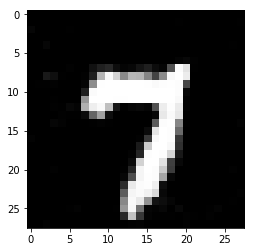

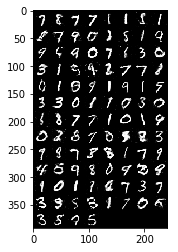

In [47]:
z = Variable(torch.randn(batch_size, z_dim)).cuda()
fake_images = G(z)
plt.imshow(denorm(fake_images[2].cpu().view(28,28).data).numpy(), cmap='gray')
plt.show()

plt.imshow(make_grid(denorm(fake_images.data.view(batch_size,1,28,28))).cpu().permute(1,2,0).numpy())
plt.show()